# Project : Finding lane lines on the road

## Submitted by Anirudh Tibrewal


## Import Packages

In [61]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline
global left_polyfit
global right_polyfit

## Read In Image/Video file

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


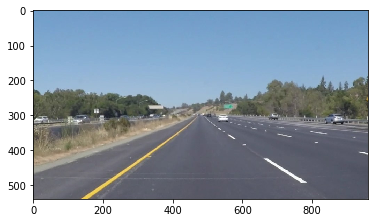

In [62]:
#import image
import os

#reading in an image
image = mpimg.imread('test_images/solidYellowLeft.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

In [111]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
   
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    ##draw_lines_lr(line_img, lines)
    draw_lines_vid(line_img, lines)
    ##draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

def draw_lines_lr(image, lines):

    '''
    
    function to draw two lines representing the left and right lanes
    
    '''
    left_fit = [] ##lists the slope and y-intercept of all the lines on the left lane
    right_fit = [] ##lists the slope and y-intercept of all the lines on the right lane
   
    for line in lines:
        for x1,y1,x2,y2 in line:
            parameters = np.polyfit((x1, x2), (y1, y2), 1)  ## numpy.polyfit obtains the slope and y-intercet of the line
            
            slope = parameters[0]
            intercept = parameters[1]
            if slope < 0:
                left_fit.append((slope, intercept))
            else:
                right_fit.append((slope, intercept))
    if left_fit:
        left_fit_average = np.average(left_fit, axis = 0)  ### averaging the slope and y-intercept of left line
        left_line = find_points(image, left_fit_average) ### using find_points to find the endpoints of the line to be drawn
        xl1, yl1, xl2, yl2 = left_line
        cv2.line(image, (xl1, yl1), (xl2, yl2), color=[255, 0, 0], thickness=5) ###line drawn on the image
    
    if right_fit:
        right_fit_average = np.average(right_fit, axis = 0)
        right_line = find_points(image, right_fit_average)
        xr1, yr1, xr2, yr2 = right_line
        cv2.line(image, (xr1, yr1), (xr2, yr2), color=[255, 0, 0], thickness=5)
        
        
        
def draw_lines_vid(image, lines):

    '''
    
    function to draw two lines representing the left and right lanes including averaging of lane lines for videos
    
    '''
    left_fit = [] ##lists the slope and y-intercept of all the lines on the left lane
    right_fit = [] ##lists the slope and y-intercept of all the lines on the right lane
   
    for line in lines:
        for x1,y1,x2,y2 in line:
            parameters = np.polyfit((x1, x2), (y1, y2), 1)  ## numpy.polyfit obtains the slope and y-intercet of the line
            
            slope = parameters[0]
            intercept = parameters[1]
            if slope < 0:
                left_fit.append((slope, intercept))
            else:
                right_fit.append((slope, intercept))
    if left_fit:
        left_fit_average = np.average(left_fit, axis = 0)  ### averaging the slope and y-intercept of left line
        left_polyfit.append(left_fit_average)
        left_average = np.average(left_polyfit, axis = 0)
        left_line = find_points(image, left_average)
        if len(left_polyfit) > 30:
            del left_polyfit[0]
        xl1, yl1, xl2, yl2 = left_line
        cv2.line(image, (xl1, yl1), (xl2, yl2), color=[255, 0, 0], thickness=5)
    
    if right_fit:
        right_fit_average = np.average(right_fit, axis = 0)
        right_polyfit.append(right_fit_average)
        
        right_average = np.average(right_polyfit, axis=0)
        right_line = find_points(image, right_average)
        if len(right_polyfit) > 30:
            del right_polyfit[0]
        xr1, yr1, xr2, yr2 = right_line
        cv2.line(image, (xr1, yr1), (xr2, yr2), color=[255, 0, 0], thickness=5)
    
    
def find_points(image, line):
    '''
    function to find endpoints from slope and intercept
    '''
    if line is None:
        return None
    slope, intercept = line
    y1 = int(image.shape[0])
    y2 = int(y1*3/5)         # approximately the middle of the image
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    points = x1, y1, x2, y2
    return points



## Setting up Canny to detect lane lines

In [112]:
#Creating a grayscale of the image
gray = grayscale(image)

#Defining a kernel size for Gaussian blurring/smoothing
kernel_size = 3
blur_gray = gaussian_blur(gray, kernel_size)

#Defining parameters for canny
low_threshold = 100
high_threshold = 200
edges = canny(blur_gray, low_threshold, high_threshold)


## Performing Image Masking

In [113]:
ysize = image.shape[0]
xsize = image.shape[1]

##Vertices of the masking area
masking_area = np.array([[(120, ysize), (900, ysize), (700, 400), (200, 400), ]], np.int32)



masked_canny = region_of_interest(edges, masking_area)

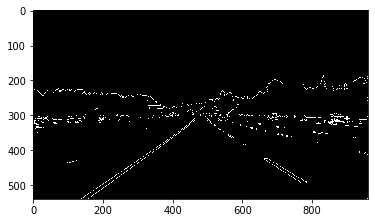

In [114]:
plt.imshow(edges, cmap='Greys_r')

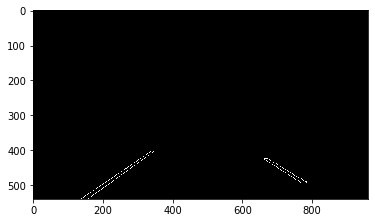

In [115]:
plt.imshow(masked_canny, cmap='Greys_r')

## Parameterising Hough Transform

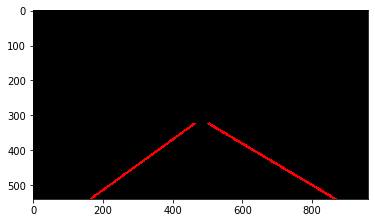

In [116]:
##Defining value of variables
rho = 5 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 100
# minimum number of votes (intersections in Hough grid cell)
min_line_length = 10 #minimum number of pixels making up a line
max_line_gap = 10    # maximum gap in pixels between connectable line segments

##Run Hough on Detected Image

lines = hough_lines(masked_canny, rho, theta, threshold, min_line_length, max_line_gap)
plt.imshow(lines)

## Hough lines drawn on the image

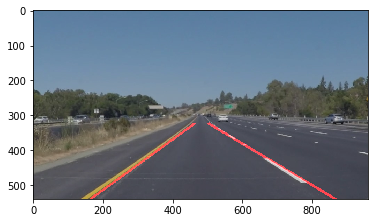

In [117]:
hough_lines_image = weighted_img(lines, image, α=0.8, β=1., γ=0.)
plt.imshow(hough_lines_image, cmap='Greys_r')

## Writing the lane detected image to OS

In [103]:
cv2.imwrite('test_image_output/SolidYellowLeftOutput.jpg', hough_lines_image)

True

## Importing libraries required to run video files

In [104]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### Function to perform the image processing pipeline

In [108]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    #Creating a grayscale of the image
    gray = grayscale(image)

    #Defining a kernel size for Gaussian blurring/smoothing
    kernel_size = 3
    blur_gray = gaussian_blur(gray, kernel_size)

    #Defining parameters for canny
    low_threshold = 100
    high_threshold = 200
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    ysize = image.shape[0]
    xsize = image.shape[1]

    ##Vertices of the masking area
    masking_area = np.array([[(120, ysize), (900, ysize), (550, 350), (400, 350), ]], np.int32)



    masked_canny = region_of_interest(edges, masking_area)
    
    ##Defining value of variables
    rho = 3 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 60
    # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 75 #minimum number of pixels making up a line
    max_line_gap = 75    # maximum gap in pixels between connectable line segments

    ##Run Hough on Detected Image

    lines = hough_lines(masked_canny, rho, theta, threshold, min_line_length, max_line_gap)

    result = weighted_img(lines, image, α=0.8, β=1., γ=0.)

    return result

In [109]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
left_polyfit = []
right_polyfit = []
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

                                                                    

                                                        
                                                                 


t:   1%|          | 5/681 [3:10:33<429:24:31, 2286.79s/it, now=None]

t:   1%|          | 5/681 [3:08:04<423:47:39, 2256.89s/it, now=None]


                                                                    

                                                        
                                                                 


t:   1%|          | 5/681 [3:10:34<429:24:38, 2286.80s/it, now=None]

t:   1%|          | 5/681 [3:08:04<423:47:47, 2256.90s/it, now=None]


t:   2%|▏         | 5/221 [2:49:49<00:08, 24.32it/s, now=None]



t:   0%|          | 0/221 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4







t:   2%|▏         | 5/221 [00:00<00:05, 41.76it/s, now=None]



t:   5%|▍         | 11/221 [00:00<00:04, 45.19it/s, now=None]



t:   8%|▊         | 18/221 [00:00<00:04, 50.46it/s, now=None]



t:  11%|█▏        | 25/221 [00:00<00:03, 54.09it/s, now=None]



t:  14%|█▍        | 31/221 [00:00<00:03, 54.69it/s, now=None]



t:  17%|█▋        | 37/221 [00:00<00:03, 55.74it/s, now=None]



t:  19%|█▉        | 43/221 [00:00<00:04, 43.51it/s, now=None]



t:  22%|██▏       | 48/221 [00:01<00:05, 34.18it/s, now=None]



t:  24%|██▎       | 52/221 [00:01<00:05, 33.55it/s, now=None]



t:  25%|██▌       | 56/221 [00:01<00:05, 29.13it/s, now=None]



t:  27%|██▋       | 60/221 [00:01<00:05, 27.49it/s, now=None]



t:  29%|██▊       | 63/221 [00:01<00:06, 24.49it/s, now=None]



t:  30%|██▉       | 66/221 [00:01<00:06, 22.70it/s, now=None]



t:  31%|███       | 69/221 [00:02<00:06, 21.86it/s, now=None]



t:  33%|███▎      | 72/221 [00:02<00:06, 21.73it/s, now=None]



t:  34%|███▍      | 75

Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
CPU times: user 3.04 s, sys: 522 ms, total: 3.56 s
Wall time: 9.38 s


# Yellow Output

In [110]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
left_polyfit = []
right_polyfit = []
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

                                                                    

                                                        
                                                                 


t:   1%|          | 5/681 [3:10:44<429:49:11, 2288.98s/it, now=None]

t:   1%|          | 5/681 [3:08:15<424:12:22, 2259.09s/it, now=None]


                                                                    

                                                        
                                                                 


t:   1%|          | 5/681 [3:10:45<429:49:24, 2289.00s/it, now=None]

t:   1%|          | 5/681 [3:08:15<424:12:33, 2259.10s/it, now=None]


t:   2%|▏         | 5/221 [2:50:00<00:08, 24.32it/s, now=None]



t:   0%|          | 0/681 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4







t:   1%|          | 6/681 [00:00<00:12, 53.87it/s, now=None]



t:   1%|▏         | 9/681 [00:00<00:15, 42.54it/s, now=None]



t:   2%|▏         | 12/681 [00:00<00:19, 33.82it/s, now=None]



t:   2%|▏         | 16/681 [00:00<00:19, 34.68it/s, now=None]



t:   3%|▎         | 23/681 [00:00<00:16, 40.73it/s, now=None]



t:   4%|▍         | 30/681 [00:00<00:14, 46.16it/s, now=None]



t:   5%|▌         | 35/681 [00:00<00:13, 46.48it/s, now=None]



t:   6%|▌         | 40/681 [00:00<00:13, 47.27it/s, now=None]



t:   7%|▋         | 45/681 [00:01<00:15, 41.69it/s, now=None]



t:   7%|▋         | 50/681 [00:01<00:18, 34.22it/s, now=None]



t:   8%|▊         | 54/681 [00:01<00:23, 27.09it/s, now=None]



t:   9%|▊         | 58/681 [00:01<00:23, 26.01it/s, now=None]



t:   9%|▉         | 61/681 [00:01<00:27, 22.25it/s, now=None]



t:   9%|▉         | 64/681 [00:01<00:29, 20.76it/s, now=None]



t:  10%|▉         | 67/681 [00:02<00:28, 21.91it/s, now=None]



t:  10%|█         | 70/

t:  53%|█████▎    | 363/681 [00:13<00:12, 24.95it/s, now=None]



t:  54%|█████▍    | 367/681 [00:14<00:11, 26.90it/s, now=None]



t:  54%|█████▍    | 371/681 [00:14<00:11, 27.47it/s, now=None]



t:  55%|█████▍    | 374/681 [00:14<00:11, 27.09it/s, now=None]



t:  56%|█████▌    | 378/681 [00:14<00:10, 28.17it/s, now=None]



t:  56%|█████▌    | 381/681 [00:14<00:11, 26.13it/s, now=None]



t:  57%|█████▋    | 385/681 [00:14<00:10, 29.01it/s, now=None]



t:  57%|█████▋    | 389/681 [00:14<00:11, 26.19it/s, now=None]



t:  58%|█████▊    | 392/681 [00:15<00:11, 24.22it/s, now=None]



t:  58%|█████▊    | 395/681 [00:15<00:11, 23.84it/s, now=None]



t:  59%|█████▊    | 399/681 [00:15<00:10, 25.77it/s, now=None]



t:  59%|█████▉    | 402/681 [00:15<00:10, 25.93it/s, now=None]



t:  60%|█████▉    | 406/681 [00:15<00:09, 28.26it/s, now=None]



t:  60%|██████    | 409/681 [00:15<00:10, 27.14it/s, now=None]



t:  60%|██████    | 412/681 [00:15<00:09, 27.93it/s, now=None]



t:  61%|██

t:   2%|▏         | 5/221 [2:50:27<00:08, 24.32it/s, now=None]

Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
CPU times: user 9.46 s, sys: 1.49 s, total: 11 s
Wall time: 27.2 s
